In [1]:
import PIL
import pandas as pd
import numpy as np
import os 
from tqdm import tqdm
import logging

import matplotlib.image as mpimg
import json

from skimage.color import rgb2gray
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors

import torch
import time
import copy
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as func
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.transforms import ToTensor,Resize

from torchvision import models
import torch.nn.functional as F
from torch.optim import lr_scheduler

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import f1_score,accuracy_score,recall_score,classification_report,confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
def load_data(foldername = 'dataset/', train_size = 310, test_size = 110):

    fileList = []
    for dirname, _, filenames in os.walk(foldername):
#         print(dirname)
#         print(filenames)
        for filename in filenames:
            if filename =='666.jpg' or filename == '11702.jpg':
                continue
            fileList.append(os.path.join(dirname, filename))

    
    classList = []

    for i in range(len(fileList)):
        if 'hunzhuo' in fileList[i]:
            classList.append('hunzhuo')
        else:
            classList.append('tuoli')

    df = pd.DataFrame({'filepath':fileList,'label':classList})  

    trainDf,testDf, trainy,testy = train_test_split(df, df.label, train_size = train_size, test_size =test_size)

    return trainDf, testDf

In [3]:
trainDf, testDf = load_data(train_size = 310, test_size = 110)

In [4]:
print(trainDf)

                          filepath    label
317      dataset/tuoli/tuoli95.jpg    tuoli
49   dataset/hunzhuo/hunzhuo49.jpg  hunzhuo
380     dataset/tuoli/tuoli158.jpg    tuoli
227       dataset/tuoli/tuoli5.jpg    tuoli
373     dataset/tuoli/tuoli151.jpg    tuoli
..                             ...      ...
330     dataset/tuoli/tuoli108.jpg    tuoli
223       dataset/tuoli/tuoli1.jpg    tuoli
347     dataset/tuoli/tuoli125.jpg    tuoli
76   dataset/hunzhuo/hunzhuo76.jpg  hunzhuo
260      dataset/tuoli/tuoli38.jpg    tuoli

[310 rows x 2 columns]


In [5]:
print(testDf)

                           filepath    label
51    dataset/hunzhuo/hunzhuo51.jpg  hunzhuo
419      dataset/tuoli/tuoli197.jpg    tuoli
218  dataset/hunzhuo/hunzhuo218.jpg  hunzhuo
403      dataset/tuoli/tuoli181.jpg    tuoli
69    dataset/hunzhuo/hunzhuo69.jpg  hunzhuo
..                              ...      ...
122  dataset/hunzhuo/hunzhuo122.jpg  hunzhuo
281       dataset/tuoli/tuoli59.jpg    tuoli
292       dataset/tuoli/tuoli70.jpg    tuoli
13    dataset/hunzhuo/hunzhuo13.jpg  hunzhuo
437      dataset/tuoli/tuoli215.jpg    tuoli

[110 rows x 2 columns]


In [6]:
def getFeat(net, imgList):

    net.eval()
    featList = []

    with torch.no_grad():
        for i in range(len(imgList)):
            feat = net.getFeatures(imgList[i])
            featList.append(feat.squeeze(0).detach().cpu().numpy())

    return np.array(featList)


In [7]:
def getCDDistribution(net,imgList, labelList ):

    uniqueClasses = [0,1]

    NUM_COLORS = 2

    # featList = []

    # for i in range(len(imgList)):
    #     feat = net.getFeatures(imgList[i])
    #     featList.append(feat.squeeze(0).detach().cpu().numpy())


    get_color = plt.get_cmap('viridis')

    colorMap = {}
    for i in range(len(uniqueClasses)):
        colorMap[uniqueClasses[i]] = get_color(i/NUM_COLORS)
    
    support = getFeat(net, imgList)
    X = support

    print(X.shape)

    # scaler = StandardScaler()
    # X = scaler.fit_transform(support)

    pca = PCA(n_components=2)
    pcaX = pca.fit_transform(X=X)
    varExplained = np.sum(pca.explained_variance_ratio_[:2])
    print(f"Variance Explained : {varExplained}")

    colors = [colorMap[int(x)] for x in labelList]
    for i in range(len(uniqueClasses)):
      index = np.array(labelList) == int(uniqueClasses[i])
      plt.scatter(pcaX[index,0], pcaX[index,1], color=colorMap[int(uniqueClasses[i])], label =int(uniqueClasses[i]))
    plt.legend()

    plt.show()

In [8]:
def getSupport(net, dataloader):

    supports = []
    labels = []

    with torch.no_grad():

        net.eval()

        for data in dataloader:
            x,y = data
            x = x.to('cuda')
            feat = net.getFeatures(x)

            supports.append(feat)
            labels.append(y)

    support = torch.cat(supports,axis=0)
    labels = torch.cat(labels,axis=0)

    return support, labels


def compareSamples(index1,index2, metric = 'cosine'):
    img1 = testX[index1].unsqueeze(0).repeat(3,1,1)
    img2 = testX[index2].unsqueeze(0).repeat(3,1,1)

    label1, label2 = testy[index1], testy[index2]

    if label1 ==label2:
        trainLabel = 1
    else:
        trainLabel = 0

    print(f"Labels are {label1} and {label2}")


    feat1 = net.getFeatures(img1.unsqueeze(0).cuda().float())
    feat2 = net.getFeatures(img2.unsqueeze(0).cuda().float())

    if metric=='cosine':
      dist = F.cosine_similarity(feat1, feat2)
    else:
      dist = F.pairwise_distance(feat1,feat2)

    loss = criterion(feat1, feat2, trainLabel)

    print(f"dist is {float(dist)} and loss is {loss}")



def getDistribution(support, labels ):

    uniqueClasses = sorted(pd.Series(labels).unique())

    NUM_COLORS = len(uniqueClasses)

    
    # get_color = matplotlib.colors.LinearSegmentedColormap.from_list(mp, colors=['r', 'y', 'g', 'b'], N=NUM_COLORS)

    get_color = plt.get_cmap('viridis')

    colorMap = {}
    for i in range(len(uniqueClasses)):
        colorMap[uniqueClasses[i]] = get_color(i/NUM_COLORS)
    
    support = support.cpu().numpy()

    scaler = StandardScaler()
    X = scaler.fit_transform(support)

    pca = PCA(n_components=2)
    pcaX = pca.fit_transform(X=X)
    varExplained = np.sum(pca.explained_variance_ratio_[:2])
    print(f"Variance Explained : {varExplained}")

    colors = [colorMap[int(x)] for x in labels]
    for i in range(len(uniqueClasses)):
      index = np.array(labels) == int(uniqueClasses[i])
      plt.scatter(pcaX[index,0], pcaX[index,1], color=colorMap[int(uniqueClasses[i])], label =int(uniqueClasses[i]))
    plt.legend()

    plt.show()


def getClassMap(uniqueClass):

    classMap = {}
    for i in range(len(uniqueClass)):
        classMap[uniqueClass[i]] = i

    classMap_ = {k:v for v,k in classMap.items()}

    return classMap, classMap_

In [9]:
def getPred(net, train_dataloader_, testDataset_, metric = 'cosine', usePCA = False, PCA_components = 10):

    support, labels = getSupport(net, train_dataloader_)

    X = support.cpu().numpy()

    pca = PCA(n_components=PCA_components)
    if usePCA:
      X = pca.fit_transform(X=X)

    knnModel = KNeighborsClassifier(n_neighbors=8,metric=metric)
    knnModel.fit(X, labels)

    labelList = []
    predList = []
    for i in tqdm(range(len(testDataset_))):
        testX = net.getFeatures(testDataset_[i][0].unsqueeze(0).cuda()).detach().cpu().numpy()
        label = int(testDataset_[i][1])
        if usePCA:
          testX = pca.transform(testX)

        pred = knnModel.predict(testX)
        predList.append(pred[0])
        labelList.append(label)

    
    return predList, labelList

In [10]:
def compareDist(net, criterion, img1, img2, label,  metric = 'cosine',printOutput=True):

    net.eval()

    output1 = net.getFeatures(img1)
    output2 = net.getFeatures(img2)

    if metric == 'cosine':
        dist = 1 - torch.nn.functional.cosine_similarity(output1, output2)
    else:
        dist = torch.nn.functional.pairwise_distance(output1, output2)
        
    loss =  criterion(output1, output2, label) 

    dist = dist.detach().cpu().numpy()

    dist = np.round(dist[0],3)

    if printOutput:
        print(f"Dist : {dist} Loss : {loss} Target Label : {int(label)}")

    return dist, loss

In [11]:
class ConfusionMatrix(object):


    def __init__(self, num_classes: int, labels: list):
        self.matrix = np.zeros((num_classes, num_classes))#初始化混淆矩阵，元素都为0
        self.num_classes = num_classes#类别数量，本例数据集类别为5
        self.labels = labels#类别标签

    def update(self, preds, labels):
        for p, t in zip(preds, labels):#pred为预测结果，labels为真实标签
            self.matrix[p, t] += 1#根据预测结果和真实标签的值统计数量，在混淆矩阵相应位置+1

    def summary(self):#计算指标函数
        # calculate accuracy
        sum_TP = 0
        n = np.sum(self.matrix)
        for i in range(self.num_classes):
            sum_TP += self.matrix[i, i]#混淆矩阵对角线的元素之和，也就是分类正确的数量
        acc = sum_TP / n#总体准确率
        print("the model accuracy is ", acc)
		
		# kappa
        sum_po = 0
        sum_pe = 0
        for i in range(len(self.matrix[0])):
            sum_po += self.matrix[i][i]
            row = np.sum(self.matrix[i, :])
            col = np.sum(self.matrix[:, i])
            sum_pe += row * col
        po = sum_po / n
        pe = sum_pe / (n * n)
        # print(po, pe)
        kappa = round((po - pe) / (1 - pe), 3)
        #print("the model kappa is ", kappa)
        
        # precision, recall, specificity
        table = PrettyTable()#创建一个表格
        table.field_names = ["", "Precision", "Recall", "Specificity"]
        for i in range(self.num_classes):#精确度、召回率、特异度的计算
            TP = self.matrix[i, i]
            FP = np.sum(self.matrix[i, :]) - TP
            FN = np.sum(self.matrix[:, i]) - TP
            TN = np.sum(self.matrix) - TP - FP - FN

            Precision = round(TP / (TP + FP), 3) if TP + FP != 0 else 0.
            Recall = round(TP / (TP + FN), 3) if TP + FN != 0 else 0.#每一类准确度
            Specificity = round(TN / (TN + FP), 3) if TN + FP != 0 else 0.

            table.add_row([self.labels[i], Precision, Recall, Specificity])
        print(table)
        return str(acc)

    def plot(self):#绘制混淆矩阵
        matrix = self.matrix
        print(matrix)
        plt.imshow(matrix, cmap=plt.cm.Blues)

        # 设置x轴坐标label
        plt.xticks(range(self.num_classes), self.labels, rotation=45)
        # 设置y轴坐标label
        plt.yticks(range(self.num_classes), self.labels)
        # 显示colorbar
        plt.colorbar()
        plt.xlabel('True Labels')
        plt.ylabel('Predicted Labels')
        plt.title('Confusion matrix (acc='+self.summary()+')')

        # 在图中标注数量/概率信息
        thresh = matrix.max() / 2
        for x in range(self.num_classes):
            for y in range(self.num_classes):
                # 注意这里的matrix[y, x]不是matrix[x, y]
                info = int(matrix[y, x])
                plt.text(x, y, info,
                         verticalalignment='center',
                         horizontalalignment='center',
                         color="white" if info > thresh else "black")
        plt.tight_layout()
        plt.show()



In [59]:
def testModel(net, imgList, labelList, testDataset_):

    correct = 0
    net.eval()
    predLabel_list = []
    pred_list = []
    trainFeat = getFeat(net,imgList)
#1
#     from sklearn.svm import SVC
#     knnModel = SVC(gamma='auto', kernel='rbf')

#2     from sklearn.ensemble import RandomForestClassifier
#     knnModel = RandomForestClassifier(n_estimators=10)

#     from sklearn.ensemble import GradientBoostingClassifier
#     knnModel = GradientBoostingClassifier()
    
#4
    from sklearn.naive_bayes import GaussianNB
 
    knnModel = GaussianNB()
#5
    knnModel = KNeighborsClassifier(n_neighbors=4)
#     metric='cosine'
    knnModel.fit(trainFeat, labelList)

    for i in tqdm(range(len(testDataset_))):
        predImg, predLabel = testDataset_[i]
        predImg = predImg.cuda().unsqueeze(0)
        predLabel_list.append(predLabel)
    
        testFeat = getFeat(net, [predImg])
        pred = knnModel.predict(testFeat)
        pred_list.extend(pred)
#         print(predLabel)
#         print(pred)
        if pred == predLabel:
            correct += 1
#     print(predLabel_list)
#     print(pred_list)
    class_report=classification_report( predLabel_list, pred_list, target_names=['class 0', 'class 1'])
    # print(f"Accuracy is : {correct/len(testDataset_)}")
    print(class_report)
    acc = np.round(correct/len(testDataset_),4)
    return acc

In [13]:
def testModel_(net, imgList, labelList):

    correct = 0
    net.eval()

    trainFeat = getFeat(net,imgList)
    from sklearn.ensemble import  AdaBoostClassifier 
 
    knnModel = AdaBoostClassifier()#0.854
#     from sklearn import tree
#     knnModel = tree.DecisionTreeClassifier()# 0.83
#     knnModel = KNeighborsClassifier(n_neighbors=10, metric='cosine')#0.90
    knnModel.fit(trainFeat, labelList)

    for i in tqdm(range(len(imgList))):
        pred = knnModel.predict(trainFeat[i,:].reshape(1,-1))

        if pred == labelList[i]:
            correct += 1

    # print(f"Accuracy is : {correct/len(imgList)}")

    acc = np.round(correct/len(imgList),4)
    return acc

In [14]:
def predictModel(net, test_dataloader_):

    net.eval()

    labelList = []
    predList = []

    with torch.no_grad():

        for (img,labels) in test_dataloader_:
            img,labels = img.cuda(), labels.cuda()
            
            outputs = net(img)
            _, preds = torch.max(outputs, 1)

            labelList = labelList + list(labels.cpu().numpy())
            predList = predList + list(preds.cpu().numpy())

    return labelList, predList

In [15]:
class SiameseDataset(torch.utils.data.Dataset):
  def __init__(self, df, prob = 0.5, transform = None, classMap= None, classMap_ = None):
#     """ 
#     df : Dataframe with filename and label columns.


#     """
    
    self.df = df
    self.transform = transform
    self.numClasses = df.label.nunique()
    self.uniqueLabels = sorted(df.label.unique())
    self.prob = prob

    if classMap is None or classMap_ is None:
        self.classMap, self.classMap_ = getClassMap(self.df.label.unique())
    else:
        self.classMap, self.classMap_ = classMap, classMap_
        
  def __len__(self):
    
    return len(self.df)
    
  def __getitem__(self, index):

    is_positive = np.random.random() < self.prob

    if is_positive:
        posLabel = np.random.choice(self.uniqueLabels,1)[0]

        # print(posLabel)
        subDf = self.df[self.df.label == posLabel] 
        subDf = subDf.sample(2, replace = False)
            
        filename1, filename2 = subDf.iloc[0]['filepath'], subDf.iloc[1]['filepath']
        img1, img2 =  Image.open(os.path.join(filename1)).convert('RGB'), Image.open(os.path.join(filename2)).convert('RGB')
        
        target_label = 1
        
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            
        # img1 = img1/255.0
        # img2 = img2/255.0

    else:

        negLabels = np.random.choice(self.uniqueLabels,2, replace = False)


        subDf1 = self.df[self.df.label == negLabels[0]].sample(1)
        subDf2 = self.df[self.df.label == negLabels[1]].sample(1)

        filename1, filename2 = subDf1.iloc[0]['filepath'], subDf2.iloc[0]['filepath']
        img1, img2 =  Image.open(os.path.join(filename1)).convert('RGB'), Image.open(os.path.join(filename2)).convert('RGB')

        target_label = 0

        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            
        # img1 = img1/255.0
        # img2 = img2/255.0


    
    return img1,img2, target_label

In [16]:
class ImageDataset(torch.utils.data.Dataset):
  def __init__(self, df, transform, classMap= None, classMap_ = None):
    
    
    self.df = df
    self.transform = transform

    if classMap is None or classMap_ is None:
        self.classMap, self.classMap_ = getClassMap(self.df.label.unique())
    else:
        self.classMap, self.classMap_ = classMap, classMap_
        
    
  def __len__(self):
    
    return len(self.df)
    
  def __getitem__(self, index):
    
    filename = self.df.iloc[index]['filepath']
    
    img =  Image.open(os.path.join(filename)).convert('RGB')

    
    label = self.classMap[self.df.iloc[index]['label']]
    
    if self.transform is not None:
        img = self.transform(img)
    
    
    # img = img/255.0
    
    return img, label

In [17]:
class ModuleHook():
    def __init__(self, module, backward=True):

        self.gradList = []

        if backward==False:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)
    
    def __getitem__(self,key):
        return self.gradList[key]

    def hook_fn(self, module, grad_input, grad_output):
        self.gradList.append(grad_output.cpu().numpy())

    def close(self):
        self.hook.remove()


class ParamHook():
    def __init__(self, param):
        self.gradList = []
        self.hook = param.register_hook(self.hook_fn)

    def __getitem__(self, key):
        return self.gradList[key]
      
    def hook_fn(self, grad):
        meanGrad = grad.abs().mean().cpu().numpy()
        maxGrad = grad.abs().max().cpu().numpy()
        self.gradList.append([meanGrad,maxGrad])

    def close(self):
        self.hook.remove()


class gradCapture():

   def __init__(self):
     self.paramGradList = {}
     self.gradList = {}

     self.paramHooks = {}
     self.moduleHooks = {}


   def registerHooks(self, model):

     for name, param in net.named_parameters():
       self.paramHooks[name] = ParamHook(param)

   def plotGrad(self, paramList, plotMean = True, plotRange = None):

     length = len(self.paramHooks[list(self.paramHooks.keys())[0]].gradList)
     
     if plotRange :
         x = list(range(plotRange[0], plotRange[1]))
     else:
         x = list(range(length))

     for i in range(len(paramList)):
       key = paramList[i]
       if plotMean:
         y = [i[0] for i in gradCap.paramHooks[key].gradList]
       else:
         y = [i[1] for i in gradCap.paramHooks[key].gradList]

       if plotRange :
        y = np.array(y)[plotRange[0]:plotRange[1]]
    
        
       plt.plot(x,y,label=key)

     plt.legend()

In [18]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=15.0, metric='cosine'):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.metric = metric

    def forward_cosine(self, output1, output2, label):
        euclidean_distance = 1 - torch.nn.functional.cosine_similarity(output1, output2)
        # print(euclidean_distance)
        loss_contrastive = torch.mean((label) * torch.pow(euclidean_distance, 2) +
                                      (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        
        return loss_contrastive
      
    def forward_euclidean(self, output1, output2, label):
        euclidean_distance = torch.nn.functional.pairwise_distance(output1, output2)
        # print(euclidean_distance)
        loss_contrastive = torch.mean((label) * torch.pow(euclidean_distance, 2) +
                                      (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

    def forward(self, output1, output2, label):

      if self.metric =='cosine':
        loss = self.forward_cosine(output1, output2, label)
      elif self.metric=='euclidean':
        loss = self.forward_euclidean(output1, output2, label)
      
      return loss

# 实验

In [19]:
train_transform = transforms.Compose([
                                      transforms.Resize((224,224)),
#         transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
                                     transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [24]:
NUM_TRAIN_SAMPLES = 310
NUM_TEST_SAMPLES = 110
STEPS_PER_EPOCH = 250
NUM_EPOCHS =100
EMBEDDING_SIZE = 100

In [25]:
def ConvNormRelu(inChannels, outChannels, kernel=5, stride=2):

    module = nn.Sequential(nn.Conv2d(in_channels=inChannels, out_channels=outChannels, kernel_size=kernel, stride = stride ),
                           nn.BatchNorm2d(outChannels),
                           nn.ReLU())

    return module

class Net(nn.Module):

    def __init__(self,activation = 'relu'):
        super().__init__()

        self.activation = activation

        self.pool = nn.MaxPool2d(2)

        self.conv1 = ConvNormRelu(3,64,7,2)
        self.conv2 = ConvNormRelu(64,128,5,2)
        self.conv3 = ConvNormRelu(128,256,5,1)
        self.conv4 = ConvNormRelu(256,256,3,1)
         
        self.drop = nn.Dropout2d(0.1)
        
        self.linear = nn.Linear(4096, EMBEDDING_SIZE)



    def getFeatures(self, x):

        x = self.conv1(x)
        x = self.pool(x)
        x = self.drop(x)

        x = self.conv2(x)

        x = self.conv3(x)
        x = self.drop(x)
        x = self.pool(x)

        x = self.conv4(x)
        x = self.pool(x)
        x = self.drop(x)
        
        x = x.view(x.shape[0], -1)
        
        x = self.linear(x)

        if self.activation=='relu':
            x = F.relu(x)
        else:
            x = torch.sigmoid(x)

        return x

    def forward(self, x1, x2):

        out1 = self.getFeatures(x1)
        out2 = self.getFeatures(x2)

        return out1, out2

# 通道注意力

In [26]:
class ChannelAttention(nn.Module):
    def __init__(self, in_planes=512, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc1   = nn.Conv2d(in_planes, in_planes // 16, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2   = nn.Conv2d(in_planes // 16, in_planes, 1, bias=False)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)


In [27]:
ca =ChannelAttention()

# 空间注意力机制

In [28]:
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=3):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)


In [29]:
sa = SpatialAttention()

In [30]:
vgg_16 = models.vgg16(pretrained=False)
pthfile = r'vgg16-397923af.pth'
vgg_16.load_state_dict(torch.load(pthfile))
vgg_feature = vgg_16.features

In [3]:
for parameters in vgg_feature.parameters():
    print(parameters)

Parameter containing:
tensor([[[[-5.5373e-01,  1.4270e-01,  5.2896e-01],
          [-5.8312e-01,  3.5655e-01,  7.6566e-01],
          [-6.9022e-01, -4.8019e-02,  4.8409e-01]],

         [[ 1.7548e-01,  9.8630e-03, -8.1413e-02],
          [ 4.4089e-02, -7.0323e-02, -2.6035e-01],
          [ 1.3239e-01, -1.7279e-01, -1.3226e-01]],

         [[ 3.1303e-01, -1.6591e-01, -4.2752e-01],
          [ 4.7519e-01, -8.2677e-02, -4.8700e-01],
          [ 6.3203e-01,  1.9308e-02, -2.7753e-01]]],


        [[[ 2.3254e-01,  1.2666e-01,  1.8605e-01],
          [-4.2805e-01, -2.4349e-01,  2.4628e-01],
          [-2.5066e-01,  1.4177e-01, -5.4864e-03]],

         [[-1.4076e-01, -2.1903e-01,  1.5041e-01],
          [-8.4127e-01, -3.5176e-01,  5.6398e-01],
          [-2.4194e-01,  5.1928e-01,  5.3915e-01]],

         [[-3.1432e-01, -3.7048e-01, -1.3094e-01],
          [-4.7144e-01, -1.5503e-01,  3.4589e-01],
          [ 5.4384e-02,  5.8683e-01,  4.9580e-01]]],


        [[[ 1.7715e-01,  5.2149e-01,  9.8740

In [31]:
# vgg_feature = torchvision.models.vgg16(pretrained=True).features

In [34]:
# print(vgg_feature)

In [35]:
# print(vgg_feature)

In [31]:
class vgg16_Siamese(torch.nn.Module):
    def __init__(self):

        super(vgg16_Siamese, self).__init__()
        
        self.vgg_features = vgg_feature
        self.activation = nn.ReLU()
        self.ca = ca
        self.sa =sa
        self.fc = nn.Sequential(
            nn.Linear(25088, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 1000),
            
        )

        
    def getFeatures(self,x):

        x = self.vgg_features(x)
        x = self.ca(x)*x
        x = self.sa(x)*x
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def forward(self,x1, x2):

        x1 = self.getFeatures(x1)
        x2 = self.getFeatures(x2)

        return x1, x2

In [32]:
# net = Net(activation = 'relu')
net=vgg16_Siamese()

In [33]:
print(net)

vgg16_Siamese(
  (vgg_features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding

In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# if torch.cuda.device_count() > 1:
#   net= nn.DataParallel(net)
net.to(device)
gradCap = gradCapture()
gradCap.registerHooks(net)

criterion = ContrastiveLoss(margin=0.4, metric='euclidean')

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()) ,lr = 0.00001 )

In [35]:
trainDf,testDf = load_data(train_size = NUM_TRAIN_SAMPLES, test_size = NUM_TEST_SAMPLES)

trainDataset = SiameseDataset(trainDf, prob = 0.5, transform=train_transform)

trainDataset_ = ImageDataset(trainDf, transform = train_transform)
testDataset_ = ImageDataset(testDf, transform = test_transform, classMap = trainDataset_.classMap, classMap_= trainDataset_.classMap_)

train_dataloader = DataLoader(trainDataset,
                        shuffle=True,
                         num_workers=0,
                        batch_size=50)

train_dataloader_ = DataLoader(trainDataset_,
                        shuffle=False,
                         num_workers=0,
                        batch_size=50)

test_dataloader_ = DataLoader(testDataset_,
                        shuffle=False,
#                         num_workers=1,
                        batch_size=200)

In [36]:
print(len(testDataset_))

110


In [39]:
indexes = list(range(NUM_TRAIN_SAMPLES))

trainImgList = []
trainLabelList = []

for i in range(len(indexes)):
    x, y = trainDataset_[indexes[i]]
    trainImgList.append(x)
    trainLabelList.append(y)
    trainImgList[i] = trainImgList[i].cuda().unsqueeze(0)

In [37]:
net.train()

for epoch in range(NUM_EPOCHS):
    epoch_loss = []
#     support, labels = getSupport(net, train_dataloader_)
#     getDistribution(support, labels)
#     plt.show()

    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
 
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()

        epoch_loss.append(loss_contrastive.item())


    print(f"Epoch Loss : {np.mean(epoch_loss)}")


# support, labels = getSupport(net, train_dataloader_)
# getDistribution(support, labels)
# plt.show()

Epoch Loss : 1.135354335818972
Epoch Loss : 0.16708581894636154
Epoch Loss : 0.05354711094072887
Epoch Loss : 0.04123545331614358
Epoch Loss : 0.040844845452478955
Epoch Loss : 0.04023092293313572
Epoch Loss : 0.0399138762482575
Epoch Loss : 0.04209293584738459
Epoch Loss : 0.04091444930859974
Epoch Loss : 0.039493344724178314
Epoch Loss : 0.039980621210166385
Epoch Loss : 0.039959611637251716
Epoch Loss : 0.040761787444353104
Epoch Loss : 0.04002238597188677
Epoch Loss : 0.040087745657988956
Epoch Loss : 0.040017055613654
Epoch Loss : 0.04045331957084792
Epoch Loss : 0.03964795491525105
Epoch Loss : 0.039757129337106435
Epoch Loss : 0.0391406523329871
Epoch Loss : 0.04036632180213928
Epoch Loss : 0.04041200131177902
Epoch Loss : 0.039923985089574544
Epoch Loss : 0.039477232843637466
Epoch Loss : 0.04018079063722065
Epoch Loss : 0.04021632777793067
Epoch Loss : 0.0398869344166347
Epoch Loss : 0.04044027626514435
Epoch Loss : 0.03992636767881257
Epoch Loss : 0.040299155350242345
Epoch L

In [39]:
# for epoch in tqdm(range(50)):
#     for i in range(STEPS_PER_EPOCH):
#         selectIndex = np.random.choice(list(range(len(indexes))),2, replace = False)
#         img1, img2 = trainImgList[selectIndex[0]], trainImgList[selectIndex[1]]

#         label1,label2 = trainLabelList[selectIndex[0]], trainLabelList[selectIndex[1]]

#         target_label = int(label1 == label2)
#         label = torch.FloatTensor([target_label]).cuda()

#         img1, img2, label = img1.cuda(), img2.cuda(), label.cuda()

#         # dist_, loss_ = compareDist(net, criterion, img1, img2, label, printOutput=False)

#         net.train()
#         optimizer.zero_grad()
#         output1,output2 = net(img1,img2)
#         loss_contrastive = criterion(output1,output2,label)
#         loss_contrastive.backward()
#         optimizer.step()
#         # scheduler.step()

#         # dist, loss = compareDist(net, criterion, img1, img2, label, printOutput=False)
#         # print(f"Indexes : [{selectIndex[0]},{selectIndex[1]}] Label : {int(label)} Old dist : {np.round(dist_,4)} New dist : {np.round(dist,4)}")

#     # testAcc = testModel(net,imgList, labelList, testDataset_)
#     trainAcc = testModel_(net,trainImgList, trainLabelList)

#     print(f"Train Acc : {trainAcc}")

(310, 1000)
Variance Explained : 0.9100393056869507


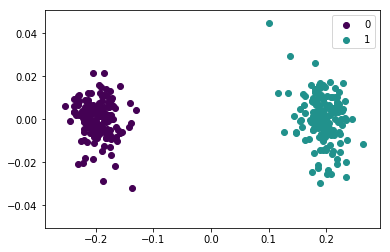

In [36]:
getCDDistribution(net, trainImgList, trainLabelList)

In [60]:
testAcc = testModel(net,trainImgList, trainLabelList, testDataset_)
# trainAcc = testModel_(net,trainImgList, trainLabelList)

print(f" Test Acc : {testAcc}")

100%|██████████| 110/110 [00:29<00:00,  3.79it/s]

              precision    recall  f1-score   support

     class 0       0.90      0.90      0.90        52
     class 1       0.91      0.91      0.91        58

    accuracy                           0.91       110
   macro avg       0.91      0.91      0.91       110
weighted avg       0.91      0.91      0.91       110

 Test Acc : 0.9091


In [38]:
torch.cuda.empty_cache()

knn(我们的模型最优结果)

第一次 
weighted avg       0.963      0.960      0.962       110
Test Acc 0.9636 

第二次
weighted avg       0.930      0.920     0.928       110
Test Acc:0.929

第三次
weighted avg  0.940 0.940 0.935   110
Test Acc: 0.936 

第四次
weighted avg  0.936 0.940 0.935   110
Test Acc: 0.936 

第五次
weighted avg  0.941 0.940 0.935   110
Test Acc: 0.936 

RandomForestClassifier

第一次
weighted avg       0.87      0.86      0.86       110

 Test Acc : 0.8636

第二次
weighted avg       0.92      0.91      0.91       110

 Test Acc : 0.9091
 
第三次
weighted avg       0.90      0.90      0.90       110

 Test Acc : 0.9
 
第四次

weighted avg       0.87      0.87      0.87       110

 Test Acc : 0.8727
 
第五次

weighted avg       0.93      0.93      0.93       110

 Test Acc : 0.9273

GBDT

第一次
weighted avg       0.89      0.88      0.88       110

 Test Acc : 0.8818

第二次
weighted avg       0.87      0.85      0.86       110

 Test Acc : 0.8545
 
第三次
weighted avg       0.84      0.84      0.84       110

 Test Acc : 0.8364

第四次
weighted avg       0.88      0.88      0.88       110

 Test Acc : 0.8818
 
第五次
weighted avg       0.61      0.61      0.61       110

 Test Acc : 0.6091


SVM

第一次
weighted avg       0.21      0.46      0.29       110

 Test Acc : 0.4636

第二次
weighted avg       0.14      0.37      0.20       110

 Test Acc : 0.3727

第三次
weighted avg       0.25      0.50      0.33       110

 Test Acc : 0.5
 
第四次
weighted avg       0.17      0.41      0.24       110

Test Acc : 0.4091

第五次
weighted avg       0.55      0.54      0.49       110

 Test Acc : 0.5364

GAUSSIONNB

第一次

weighted avg       0.91      0.90      0.90       110

 Test Acc : 0.9

第二次
weighted avg       0.86      0.85      0.85       110

 Test Acc : 0.8455
 
第三次
weighted avg       0.25      0.50      0.33       110

 Test Acc : 0.5
 
第四次
weighted avg       0.87      0.86      0.86       110

 Test Acc : 0.8636
 
第五次
weighted avg       0.61      0.60      0.59       110

 Test Acc : 0.6

n = 20

precision    recall  f1-score   support

     class 0       0.91      0.92      0.91        52
     class 1       0.93      0.91      0.92        58

    accuracy                           0.92       110
   macro avg       0.92      0.92      0.92       110
weighted avg       0.92      0.92      0.92       110

 Test Acc : 0.9182

n = 40

precision    recall  f1-score   support

     class 0       0.91      0.92      0.91        52
     class 1       0.93      0.91      0.92        58

    accuracy                           0.92       110
   macro avg       0.92      0.92      0.92       110
weighted avg       0.92      0.92      0.92       110

 Test Acc : 0.9182

n =80

precision    recall  f1-score   support

     class 0       0.91      0.92      0.91        52
     class 1       0.93      0.91      0.92        58

    accuracy                           0.92       110
   macro avg       0.92      0.92      0.92       110
weighted avg       0.92      0.92      0.92       110

 Test Acc : 0.9182

n = 100

    precision    recall  f1-score   support

     class 0       0.89      0.94      0.92        52
     class 1       0.95      0.90      0.92        58

    accuracy                           0.92       110
   macro avg       0.92      0.92      0.92       110
weighted avg       0.92      0.92      0.92       110

 Test Acc : 0.9182

n = 200


    precision    recall  f1-score   support

     class 0       0.89      0.94      0.92        52
     class 1       0.95      0.90      0.92        58

    accuracy                           0.92       110
   macro avg       0.92      0.92      0.92       110
weighted avg       0.92      0.92      0.92       110

 Test Acc : 0.9182

In [61]:
import timm